## 大規模圖像檢索(Large-Scale Image Retrieval)

In [1]:
!rm -rf pattern-recognition/
!git clone https://github.com/loucadgarbon/pattern-recognition.git

Cloning into 'pattern-recognition'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 170 (delta 43), reused 134 (delta 18), pack-reused 0
Receiving objects: 100% (170/170), 56.75 MiB | 30.73 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [2]:
!pip install kornia -q
!pip install kornia_moons -q
!pip install faiss-cpu
!pip install opencv-python --upgrade

In [3]:
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
from kornia_moons.feature import *
import os
from glob import glob
import faiss
import pandas as pd

### 演算法架構


* 索引階段
1. [萃取索引圖像的特徵](#scrollTo=kte4Ptk-IFJZ&line=1&uniqifier=1)
2. [儲存特徵至資料庫](#scrollTo=pHxmUrkxf6qs&line=1&uniqifier=1)
3. [儲存資料庫至磁碟](#scrollTo=E_1I3A5mwSx7&line=1&uniqifier=1)
* 查詢階段
1. [從磁碟載入資料庫](#scrollTo=_KvKA-J6w7nt&line=1&uniqifier=1)
2. [萃取查詢圖像的特徵](#scrollTo=v5JKFxZ8IFJe&line=1&uniqifier=1)
3. [查詢資料庫，找出特徵較相似的圖像](#scrollTo=YPj-4oFbIFJf&line=1&uniqifier=1)
4. [使用MAGSAC++進行重新排序](#scrollTo=bTs8kjPyIFJf&line=1&uniqifier=1)
5. [用閾值判定查詢圖像是否在索引類別內](#scrollTo=HbKUPb5UIFJg)

### 相關技術參考資料
* [SIFT](https://iter01.com/588786.html)
* [HardNet](https://arxiv.org/abs/1705.10872)
* [AffineNet](https://arxiv.org/abs/1711.06704)
* [MAGSAC](https://openaccess.thecvf.com/content_CVPR_2020/papers/Barath_MAGSAC_a_Fast_Reliable_and_Accurate_Robust_Estimator_CVPR_2020_paper.pdf)
* [faiss、IVF、PQ](https://www.gushiciku.cn/pl/gki5/zh-tw)

### 索引階段

#### 1. 萃取索引圖像的特徵

In [4]:
sift_det =  cv2.SIFT_create(8000)
hardnet8 = KF.HardNet8(True).eval()
affnet = KF.LAFAffNetShapeEstimator(True).eval()
orienter = KF.LAFOrienter(32, angle_detector=KF.OriNet(True)).eval()

In [5]:
def feature_extract(fname, detector, affine, descriptor, orienter, visualize=False):
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if visualize:
        plt.imshow(img)
    kpts = detector.detect(img, None)
    with torch.no_grad():
        timg = K.image_to_tensor(img, False).float()/255.
        timg_gray = K.color.rgb_to_grayscale(timg)
        lafs = laf_from_opencv_SIFT_kpts(kpts)
        lafs_new = orienter(affine(lafs, timg_gray), timg_gray)
        if visualize:
            visualize_LAF(timg, lafs_new, 0)
        patches = KF.extract_patches_from_pyramid(timg_gray,lafs_new, 32)
        B, N, CH, H, W = patches.size()
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B * N, -1)
    return descs.detach().cpu().numpy(), kpts

##### 視覺化特徵

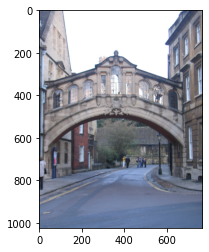

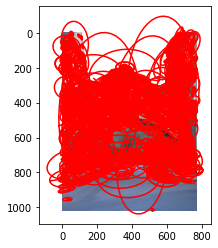

In [6]:
fname = 'pattern-recognition/final_project/index_ds/Hertford/hertford_000026.jpg'
kpts, descs = feature_extract(fname,  sift_det, affnet, hardnet8, orienter, True)

#### 2. 儲存特徵至資料庫

##### 1. 將索引圖像的特徵存放至字典
|變數|用途|
|--------|------|
|db_index|特徵索引|
|db_kpts|特徵位置|
|db_desc|特徵|
|db_label|資料類別|
|db_label_id|資料索引|
|db_fname|資料名稱|

In [7]:
index_dir= 'pattern-recognition/final_project/index_ds'

In [8]:
db_index = np.array([0], dtype=np.uint32)
db_kpts = np.array([], dtype=np.object_)
db_desc = np.empty([0, 128], dtype=np.float32)
db_label = np.array([], dtype=np.str_)
db_label_id = np.array([], dtype=np.int64)
db_fname = np.array([], dtype=np.str_)
db_index_cnt = 0
idx_cnt = 0
total = len(glob(index_dir+'/*/*'))
for idx, folder in enumerate(sorted(glob(index_dir+'/*'))):
    label = os.path.basename(folder)
    for fname in glob(folder+'/*'):
        desc, kpts = feature_extract(fname,  sift_det, affnet, hardnet8, orienter)
        db_index_cnt = np.uint32(db_index_cnt + len(desc))
        db_index = np.append(db_index, db_index_cnt)
        db_kpts = np.append(db_kpts, kpts)
        db_desc = np.vstack([db_desc, desc])
        db_label = np.append(db_label, label)
        db_label_id = np.append(db_label_id, [idx]*len(desc))
        db_fname = np.append(db_fname, fname)
        idx_cnt = idx_cnt + 1

In [9]:
db = {"db_index":db_index, "db_kpts":db_kpts, "db_desc":db_desc, "db_label":db_label, "db_label_id": db_label_id, "db_fname":db_fname}

##### 2. 使用faiss建立資料庫

In [10]:
d = 128
m = 128
nbits = 8
nlist = 50
db_learn = db['db_desc'][np.random.choice(db['db_desc'].shape[0], int(db['db_desc'].shape[0]/10), replace=False), :]
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, nbits)
index.train(db_learn)
index.add_with_ids(db['db_desc'], db['db_label_id'])

#### 3. 儲存資料庫至磁碟

In [11]:
os.makedirs('pattern-recognition/final_project/database', exist_ok=True)

In [12]:
def kpts2tuple(kpts):
  kpts_tuple = (kpts.pt, kpts.size, kpts.angle, kpts.response, kpts.octave, kpts.class_id)
  return kpts_tuple

In [13]:
db_tu = np.array([kpts2tuple(kpt) for kpt in db['db_kpts']], dtype=object)
with open('pattern-recognition/final_project/database/db.npy', 'wb') as f:
  np.save(f, db['db_index'])
  np.save(f, db['db_desc'])
  np.save(f, db['db_label'])
  np.save(f, db['db_label_id'])
  np.save(f, db['db_fname'])
  np.save(f, db_tu)

In [14]:
faiss.write_index(index, 'pattern-recognition/final_project/database/db.index')

### 查詢階段

#### 1. 從磁碟載入資料庫

In [15]:
def tuple2kpts(tu):
  kpts = cv2.KeyPoint(
    x=tu[0][0],
    y=tu[0][1],
    size=tu[1],
    angle=tu[2],
    response=tu[3],
    octave=tu[4],
    class_id=tu[5],
  )
  return kpts

In [16]:
db = {}
with open('pattern-recognition/final_project/database/db.npy', "rb") as f:
  db["db_index"] = np.load(f)
  db["db_desc"] = np.load(f)
  db["db_label"] = np.load(f)
  db["db_label_id"] = np.load(f)
  db["db_fname"] = np.load(f)
  db_tu = np.load(f, allow_pickle=True)
  db["db_kpts"] = np.array([tuple2kpts(tu) for tu in db_tu], dtype=object)

In [17]:
index = faiss.read_index('pattern-recognition/final_project/database/db.index')

#### 2. 萃取查詢圖像的特徵

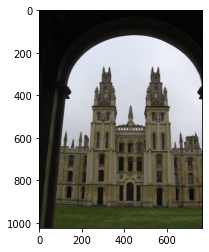

In [18]:
fname1 = 'pattern-recognition/final_project/query_ds/Allsouls/all_souls_000140.jpg'
img1 = cv2.cvtColor(cv2.imread(fname1), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

In [19]:
desc1, kpts1 = feature_extract(fname1,  sift_det, affnet, hardnet8, orienter)

#### 3. 查詢資料庫，找出特徵較相似的圖像

In [20]:
D, I = index.search(desc1, 100)
topk_arglist = np.argsort(np.bincount(I.flatten()))[::-1][:20]

#### 4. 使用MAGSAC++進行重新排序

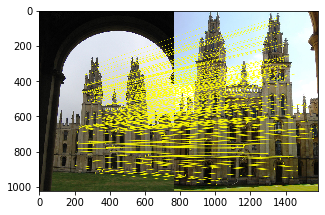

匹配度第1名
圖像名稱:all_souls_000026.jpg
類別:Allsouls
匹配點:252


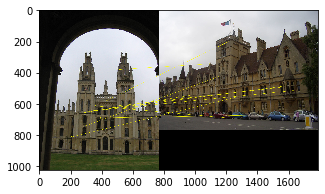

匹配度第2名
圖像名稱:balliol_000075.jpg
類別:Balliol
匹配點:10


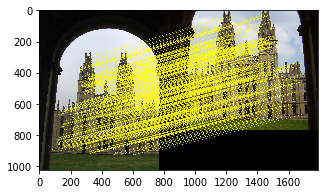

匹配度第3名
圖像名稱:all_souls_000091.jpg
類別:Allsouls
匹配點:409


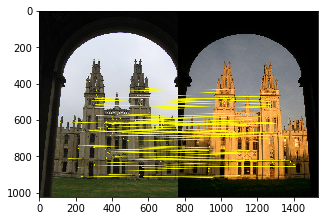

匹配度第4名
圖像名稱:all_souls_000055.jpg
類別:Allsouls
匹配點:121


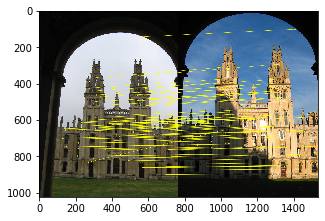

匹配度第5名
圖像名稱:all_souls_000015.jpg
類別:Allsouls
匹配點:74
預測的類別:Allsouls 


In [21]:
df = pd.DataFrame(columns=["filename", "label", "inliers"])
for idx, arg in enumerate(topk_arglist):
    kpts2 = db["db_kpts"][db["db_index"][arg] : db["db_index"][arg + 1]]
    desc2 = db["db_desc"][db["db_index"][arg] : db["db_index"][arg + 1]]
    label2 = db["db_label"][arg]
    fname2 = db["db_fname"][arg]
    dists, idxs = KF.match_smnn(
        torch.from_numpy(desc1), torch.from_numpy(desc2), 0.95
    )
    tentatives = cv2_matches_from_kornia(dists, idxs)
    src_pts = np.float32([kpts1[m.queryIdx].pt for m in tentatives]).reshape(-1, 2)
    dst_pts = np.float32([kpts2[m.trainIdx].pt for m in tentatives]).reshape(-1, 2)
    if (src_pts.shape[0] or dst_pts.shape[0]) < 8:
        continue
    H, inliers_mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
    inliers = inliers_mask.sum()
    img2 = cv2.cvtColor(cv2.imread(fname2), cv2.COLOR_BGR2RGB)
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = inliers_mask.ravel().tolist(), # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(img1,kpts1,img2,kpts2,tentatives,None,**draw_params)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img_out, interpolation='nearest')
    plt.show()
    print(
        "匹配度第{}名\n圖像名稱:{}\n類別:{}\n匹配點:{}".format(
                idx + 1, os.path.basename(fname2), label2, inliers
            )
    )
    row = pd.DataFrame(
        [[fname2, label2, inliers]], columns=["filename", "label", "inliers"]
    )
    df = pd.concat([df, row])
df = df.sort_values(by=["inliers"], ascending=False).head(5)
pred = df.head(1).label[0]
print('預測的類別:{} '.format(pred))

#### 5. 用閾值來判定查詢圖像是否在索引類別內

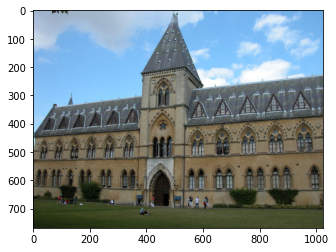

In [22]:
fname1 = 'pattern-recognition/final_project/query_ds/Pitt_rivers/pitt_rivers_000119.jpg'
img1 = cv2.cvtColor(cv2.imread(fname1), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

In [23]:
desc1, kpts1 = feature_extract(fname1,  sift_det, affnet, hardnet8, orienter)

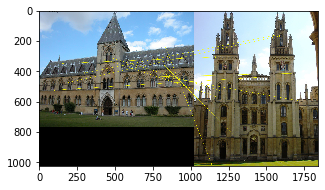

匹配度第1名
圖像名稱:all_souls_000026.jpg
類別:Allsouls
匹配點:10


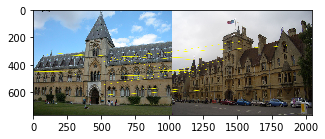

匹配度第2名
圖像名稱:balliol_000075.jpg
類別:Balliol
匹配點:11


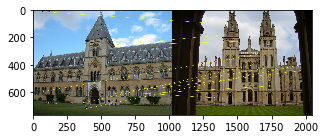

匹配度第3名
圖像名稱:all_souls_000091.jpg
類別:Allsouls
匹配點:10


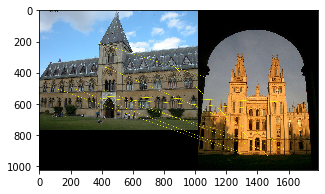

匹配度第4名
圖像名稱:all_souls_000055.jpg
類別:Allsouls
匹配點:9


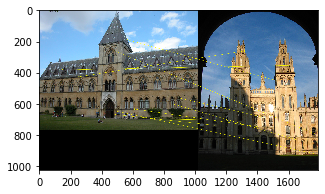

匹配度第5名
圖像名稱:all_souls_000015.jpg
類別:Allsouls
匹配點:10
預測的類別: 不在索引分類裡面


In [24]:
df = pd.DataFrame(columns=["filename", "label", "inliers"])
for idx, arg in enumerate(topk_arglist):
    kpts2 = db["db_kpts"][db["db_index"][arg] : db["db_index"][arg + 1]]
    desc2 = db["db_desc"][db["db_index"][arg] : db["db_index"][arg + 1]]
    label2 = db["db_label"][arg]
    fname2 = db["db_fname"][arg]
    dists, idxs = KF.match_smnn(
        torch.from_numpy(desc1), torch.from_numpy(desc2), 0.95
    )
    tentatives = cv2_matches_from_kornia(dists, idxs)
    src_pts = np.float32([kpts1[m.queryIdx].pt for m in tentatives]).reshape(-1, 2)
    dst_pts = np.float32([kpts2[m.trainIdx].pt for m in tentatives]).reshape(-1, 2)
    if (src_pts.shape[0] or dst_pts.shape[0]) < 8:
        continue
    H, inliers_mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
    inliers = inliers_mask.sum()
    img2 = cv2.cvtColor(cv2.imread(fname2), cv2.COLOR_BGR2RGB)
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = inliers_mask.ravel().tolist(), # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(img1,kpts1,img2,kpts2,tentatives,None,**draw_params)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img_out, interpolation='nearest')
    plt.show()
    print(
        "匹配度第{}名\n圖像名稱:{}\n類別:{}\n匹配點:{}".format(
                idx + 1, os.path.basename(fname2), label2, inliers
            )
    )
    row = pd.DataFrame(
        [[fname2, label2, inliers]], columns=["filename", "label", "inliers"]
    )
    df = pd.concat([df, row])
if df['inliers'].max() < 20:
    print('預測的類別: 不在索引分類裡面')
else:
    df = df.sort_values(by=["inliers"], ascending=False).head(5)
    pred = df.head(1).label[0]
    print('預測的類別:{} '.format(pred))